In [1]:
from OpInf import *
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import json

from scipy.io import loadmat
from operators import ckron, ckron_indices

import scienceplots
plt.style.use(["science", "no-latex", "grid"])

In [2]:
mus = [1.1, 1.05, 1, 0.95, 0.9]
# Load data

p = 2
Mp = len(mus)
dt = 1e-3
T_end = 2

config = {
    "N": 2**7 + 1 + 1,
    "dt": 1e-3,
    "T_end": T_end,
    "mus": list(mus),
    "Mp": Mp,
    "K": T_end / dt,  # T_end / dt
    "DS": 1,
    "params": {
        "modelform": "LQC",
        "modeltime": "continuous",
        "dt": dt,
        "ddt_order": "BE",
        "p": p, # polynomial order
        "lambda1": 5e-2,
        "lambda2": 5e-2,
        "lambda3": 100,
    },
    "type": "single"
}




In [3]:
Train_T = int(T_end/dt)
X_all = np.load("../examples/burgers/burgersFEniCSx_u_sol_all_RE1000.npy")[:, :Train_T+1, :]
# X_all = np.load("../examples/burgers/burgersFEniCSx_u_sol_all_RE100.npy")
print(X_all.shape)

tolerance = 1e-10
X_all[np.isclose(X_all, 0, atol=tolerance)] = 0

(5, 2001, 130)


In [4]:
import numpy as np

def ddt(X, dt, scheme):
    """
    Uses specified difference scheme to approximate dX/dt with uniform time spacing of size dt.
    
    Parameters:
    X (np.array): N-by-K data matrix where each column is the state at one time.
    dt (float): Time step.
    scheme (str): Specifies which scheme is used to approximate time derivative.
    
    Returns:
    tuple: Tuple containing:
        - np.array: N-by-M data matrix of state time derivatives.
        - np.array: M-by-1 vector of indices of state data in X.
    """
    
    N, K = X.shape

    if scheme in [1, 'FE']:  # Forward Euler integration
        dXdt = (X[:, 1:] - X[:, :-1]) / dt
        ind = np.arange(K - 1)
    elif scheme == 'BE':  # Backward Euler integration
        dXdt = (X[:, 1:] - X[:, :-1]) / dt
        ind = np.arange(1, K)
    elif scheme in [2, '2c']:  # 2nd order central differencing
        dXdt = (X[:, 2:] - X[:, :-2]) / (2 * dt)
        ind = np.arange(1, K - 1)
    elif scheme == '2imp':  # 2nd order backward differencing (implicit)
        dXdt = (3 * X[:, 2:] - 4 * X[:, 1:-1] + X[:, :-2]) / (2 * dt)
        ind = np.arange(2, K)
    elif scheme == '2ex':  # 2nd order forward differencing (explicit)
        dXdt = (-3 * X[:, :-2] + 4 * X[:, 1:-1] - X[:, 2:]) / (2 * dt)
        ind = np.arange(K - 2)
    elif scheme in [4, '4c']:  # 4th order central differencing
        dXdt = (X[:, :-4] - 8 * X[:, 1:-3] + 8 * X[:, 3:-1] - X[:, 4:]) / (12 * dt)
        ind = np.arange(2, K - 2)
    elif scheme == '4imp':  # 4th order backward differencing
        dXdt = (25 / 12 * X[:, 4:] - 4 * X[:, 3:-1] + 3 * X[:, 2:-2] - 4 / 3 * X[:, 1:-3] + 1 / 4 * X[:, :-4]) / dt
        ind = np.arange(4, K)
    elif scheme == '4ex':  # 4th order forward differencing
        dXdt = (-25 / 12 * X[:, :-4] + 4 * X[:, 1:-3] - 3 * X[:, 2:-2] + 4 / 3 * X[:, 3:-1] - 1 / 4 * X[:, 4:]) / dt
        ind = np.arange(K - 4)
    else:
        raise ValueError('Specified difference scheme not implemented')

    return dXdt, ind

# Note: Function calls are commented out to adhere to instructions. They should be uncommented for testing purposes.
# Example of function call (commented out):
# X = np.random.rand(10, 5)  # Example



def rhs(t, state, operators, multi_indices, modelform, input_func=None):
    r"""Evaluate the right-hand side of the model by applying each operator
    and summing the results.

    This is the function :math:`\Ophat(\qhat, \u)`
    where the model can be written as one of the following:

    * :math:`\ddt\qhat(t) = \Ophat(\qhat(t), \u(t))` (continuous time)
    * :math:`\qhat_{j+1} = \Ophat(\qhat_j, \u_j)` (discrete time)
    * :math:`\widehat{\mathbf{g}} = \Ophat(\qhat, \u)` (steady state)

    Parameters
    ----------
    state : (r,) ndarray
        State vector.
    input_ : (m,) ndarray or None
        Input vector corresponding to the state.

    Returns
    -------
    evaluation : (r,) ndarray
        Evaluation of the right-hand side of the model.
    """
    state = np.atleast_1d(state)
    
    # print("State shape: ", state.shape)
    
    out = np.zeros(state.shape, dtype=float)
    # gs = gen_poly(state[:, None], p=2)  # Assuming gen_poly is designed for column vector input
    
    # print("Solving for regularization parameters: ", params['lambda1'], params['lambda2'], params['lambda3'])
    
    if 'L' in modelform:
        # print("adding A")
        out += operators['A'] @ state
    
    if 'Q' in modelform:
        # ssq = get_x_sq(state[:, None].T).T  # Assuming get_x_sq can handle the shape
        # out += operators['F'] @ ssq.flatten()
        # print("adding F")
        r, r2 = operators["F"].shape
        mask = ckron_indices(r)
        
        if operators["F"].shape[0] == 1:
            return operators["F"][0, 0] * state**2  # r = 1
        
        out += (operators["F"] @ np.prod(state[mask], axis=1))
        
    if 'P' in modelform:
        gs = gen_poly(state[:, None], p=p, multi_indices=multi_indices)  # Assuming gen_poly is designed for column vector input
        out += (operators['P'] @ gs).flatten()
        
    if 'C' in modelform:
        out += operators['C'].flatten()
    
    return out


max idx =  12
max idx =  32
max idx =  50
max idx =  61


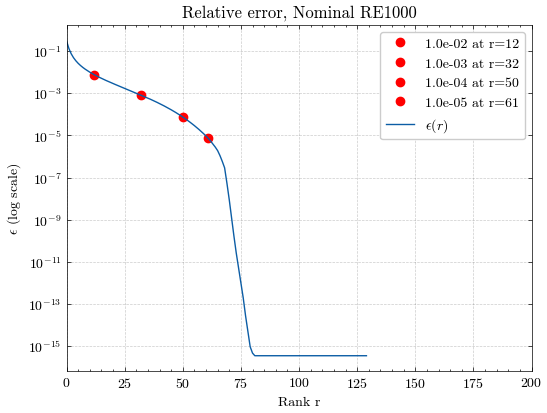

In [18]:
err_tols = [1e-2, 1e-3, 1e-4, 1e-5]
max_idx_lst = []
# mus = [0.01] # only one mu for now

fig, ax = plt.subplots(figsize=(6, 4.5))
for err_tol in err_tols:
    rob_lst = []
    rel_err_SVD_lst = []
    idx_lst = []
    # for i in range(len(X_all)):
        
    X = np.concatenate([X_all[i, :, :] for i in range(Mp)], axis=0).T
    
    # X_ref is the reference state which is just defined as the mean of the snapshots 
    # X_ref = np.mean(X, axis=1)[:, None]
    X_ref = np.zeros((X.shape[0], 1))
    
    # print("X = ", X.shape)
    # print("X_ref = ", X_ref.shape)
    
    # svd
    U, S, V = np.linalg.svd((X - X_ref), full_matrices=False)
    # print("S = ", S[:5])
    eigvals_SVD = S**2 * (1 / (len(S) - 1))
    # print("eigvals_SVD = \n", eigvals_SVD[:5])
    # append U
    # print("U = ", U.shape)
    rob_lst.append(U)
    
    # calculate the relative error
    rel_err_SVD = 1 - (np.cumsum(eigvals_SVD) / np.sum(eigvals_SVD))
    rel_err_SVD_lst.append(rel_err_SVD)
    # print("rel_err_SVD = \n", rel_err_SVD[:4])

    # print the first idx when it is less than 1e-4
    idx = np.where(rel_err_SVD < err_tol)[0][0] + 1
    idx_lst.append(idx)
        

    print("max idx = ", max(idx_lst))
    max_idx_lst.append(max(idx_lst))
    
    ax.plot(idx, rel_err_SVD[idx], 'ro', label=f"{err_tol:.1e} at r={idx}")
    ax.set_yscale('log')
    ax.set_ylabel("$\epsilon(r)$ (log scale)")
    
ax.plot(rel_err_SVD_lst[0], label=f"$\epsilon(r)$")
# set limit
ax.set_xlim([0, 200])
# ax.set_ylim([1e-13, 1e-3])
# show grid
ax.grid(True, alpha=0.2)
ax.set_xlabel("Rank r")
ax.set_title("Relative error, Nominal RE1000")
ax.legend()

In [6]:
# p = 3

Vr_lst = []
Shat_lst = []

energy_list = []

for i in range(len(err_tols[:-1])):
    # print(i)
    # Model parameters
    print("Error Tolerance: ", err_tols[i])
    r = max_idx_lst[i]
    
    # Procustes problem for each mu
    X = np.concatenate([X_all[i, :, :] for i in range(Mp)], axis=0).T
    num_snapshots = X.shape[1]
    print("num_snapshots: ", num_snapshots)
    # print("X = ", X.shape)
    # X_ref = np.mean(X, axis=1)[:, None]
    X_ref = np.zeros((X.shape[0]))[:, None]
    X_centered = X - X_ref

    U, S, V = np.linalg.svd(X_centered, full_matrices=False)
    
    Vr = U[:, :r]
    q = Vr.T @ X_centered
    Proj_error = X_centered - (Vr @ q)
    
    # Reconstruction error
    recon_error = np.linalg.norm((X - X_ref - Vr @ q)) / np.linalg.norm(X - X_ref)
    print("Reconstruction Error: ", recon_error)
    
    
    
    Vr_lst.append(Vr)
    Shat_lst.append(q)


Error Tolerance:  0.01
num_snapshots:  10005


Reconstruction Error:  0.09417127865364057
Error Tolerance:  0.001
num_snapshots:  10005
Reconstruction Error:  0.030490836001372555
Error Tolerance:  0.0001
num_snapshots:  10005
Reconstruction Error:  0.009470306849817823


In [9]:
X_all_full = np.load("../examples/burgers/burgersFEniCSx_u_sol_all_RE1000.npy")
relative_error_testing_window_lst = []
relative_error_training_window_lst = []
abs_error_full_lst = []
reduced_state_errors = []
regs_lst = []

for err_idx in range(len(err_tols[:-1])):
# for i in range(1):
    # err_idx = 1

    X = np.concatenate([X_all[i, :, :] for i in range(Mp)], axis=0).T
    # X_ref = np.mean(X, axis=1)[:, None]
    X_ref = np.zeros((X.shape[0]))[:, None]
    X_centered = X - X_ref
    
    Vr = Vr_lst[err_idx]
    q = Vr.T @ X_centered
    
    r = max_idx_lst[err_idx]

    Mp = len(mus)
    Nsnapshots = X.shape[1]
    dShatdt = []
    Shat_lst = []
    # dSdt = []
    for j in range(Mp):
        start_ind = int((j) * Nsnapshots/Mp)
        end_ind = int((j+1) * Nsnapshots/Mp)
        print("start_ind: ", start_ind)
        print("end_ind: ", end_ind)
        ddtshat, ind = ddt(q[:, start_ind:end_ind], dt=dt, scheme='BE')
        # ddts, ind = ddt(X[:, start_ind:end_ind], dt=dt, scheme="BE")
        dShatdt.append(ddtshat)
        ind = np.array(ind) + int((j) * Nsnapshots/Mp)
        Shat_lst.append(q[:, ind])
        # dSdt.append(ddts)
    
    def initial_condition(coord):
        if coord <= 0.5:
            return np.sin(2 * np.pi * coord)
        
        return 0

    # update config file with truncation order r
    config['robparams'] = {
        "r": int(r)
    }

    Shat_py = np.concatenate(Shat_lst, axis=1)
    dShatdt_py = np.concatenate(dShatdt, axis=1).T
    # dSdt_py = np.hstack(dSdt)

    print("Shape of Shat_py: ", Shat_py.shape)
    print("Shape of dShatdt_py: ", dShatdt_py.shape)
    # [operators] = inferOperators_NL(Shat, U, params, dShatdt);

    operators = infer_operators_nl(Shat_py, None, config['params'], dShatdt_py)
    # operators = infer_operators_nl(q, None, config['params'], /dShatdt_py)
    
    config['robparams'] = {
    "r": int(r)
    }

    N = int(config['N'])
    dt = config['dt']
    T_end = config['T_end']
    mus = config['mus']  # Assuming mus is saved as a string that represents a Python expression
    Mp = config['Mp']
    K = int(config['K'])
    DS = config['DS']
    params = config['params']  # This will be a dictionary in Python
    robparams = config['robparams']  # This will be a dictionary in Python


    coord = np.linspace(0, 1, N)
    print("coord = ", coord.shape)
    IC = np.array([initial_condition(c) for c in coord])
    q0 = Vr.T @ (IC[:, None] - X_ref).flatten()
    time_domain = np.arange(0, T_end, dt)
    train_size = Shat_py.shape[1]


    Shat_true = Shat_lst[2]
    regs_product = [1e-3, 2e1, 15, 1e-3, 2e1, 15]
    # regs_product = [1e0, 1e0, 1, 1e0, 1e0, 1]
    # regs_product = [1e-3, 1e-3, 1, 23, 60, 10]
    # regs_product = [1e-3, 1e-2, 5, 1e-3, 1e-2, 5, 1e-3, 1e-1, 5]
    # regs, operators = train_minimize(Shat_py, dShatdt_py, Shat_true, train_size, r, regs, time_domain, q0, params, testsize=None, margin=1.1)
    regs, errors = train_gridsearch(Shat_py, dShatdt_py, Shat_true, train_size, r, regs_product, time_domain, q0, params, testsize=None, margin=1.1)
    
    regs_lst.append(regs)
    reduced_state_errors.append(errors)
    


    config['robparams'] = {
    "r": int(r)
    }
    
    
    params['lambda1'] = regs[0]
    params['lambda2'] = regs[1]
    if len(regs) > 2:
        params['lambda3'] = regs[2]

    operators = infer_operators_nl(Shat_py, None, config['params'], dShatdt_py)
    
    
    # compute the full time series
    coord = np.linspace(0, 1, N)
    print("coord = ", coord.shape)
    IC = np.array([initial_condition(c) for c in coord])
    q0 = Vr.T @ (IC[:, None] - X_ref).flatten()

    T_end_full = 8
    time_domain_full = np.arange(0, T_end_full, dt)

    multi_indices = generate_multi_indices_efficient(len(q0), p=p)

    modelform = config['params']['modelform']
    out_full = scipy.integrate.solve_ivp(
                rhs,  # Integrate this function
                [time_domain_full[0], time_domain_full[-1]],  # over this time interval
                q0,  # from this initial condition
                t_eval=time_domain_full,  # evaluated at these points
                args=[operators, multi_indices, modelform, None],  # additional arguments to rhs
                
            )

    s_hat_full = out_full.y

    s_rec_full = X_ref + Vr @ s_hat_full
    
    # convert values close to zero to zero
    
    
    abs_error_full = np.abs(X_all_full[2].T - s_rec_full)
    T_end_index = int(T_end/dt)
    
    relative_error_testing_window = np.linalg.norm(X_all_full[2].T[:, T_end_index:] - s_rec_full[:, T_end_index:], 'fro') / np.linalg.norm(X_all_full[2].T[:, T_end_index:], 'fro')
    relative_error_training_window = np.linalg.norm(X_all_full[2].T[:, :T_end_index] - s_rec_full[:, :T_end_index], 'fro') / np.linalg.norm(X_all_full[2].T[:, :T_end_index], 'fro')
    
    # convert values close to zero to zero
    # tolerance = 1e-10  # adjust this value as needed
    # s_rec_full[np.isclose(s_rec_full, 0, atol=tolerance)] = 0
    
    abs_error_full_lst.append(abs_error_full)
    relative_error_testing_window_lst.append(relative_error_testing_window)
    relative_error_training_window_lst.append(relative_error_training_window)
        

start_ind:  0
end_ind:  2001
start_ind:  2001
end_ind:  4002
start_ind:  4002
end_ind:  6003
start_ind:  6003
end_ind:  8004
start_ind:  8004
end_ind:  10005
Shape of Shat_py:  (12, 10000)
Shape of dShatdt_py:  (10000, 12)
Obtained data matrix...
Regularization parameters:  0.008349284980470903 1.1807672055499934 0
Solving...
Solved!
coord =  (130,)
Constructing least-squares solver, r=12
TRAINING 225 ROMS
(1/225) Testing ROM with (0.001, 0.001)
Obtained data matrix...
Regularization parameters:  0.001 0.001 0
Solving...
Solved!
Integrating...
INTEGRATION FAILED at t =  0.095
(2/225) Testing ROM with (0.001, 0.0020286934558567697)
Obtained data matrix...
Regularization parameters:  0.001 0.0020286934558567697 0
Solving...
Solved!
Integrating...
INTEGRATION FAILED at t =  0.059000000000000004
(3/225) Testing ROM with (0.001, 0.004115597137836078)
Obtained data matrix...
Regularization parameters:  0.001 0.004115597137836078 0
Solving...
Solved!
Integrating...
INTEGRATION FAILED at t =  

In [11]:
err_tols

[0.01, 0.001, 0.0001, 1e-05]

In [10]:
print("Regs: ", regs_lst)
print("errors: ", reduced_state_errors)
print("Relative Errors: ", relative_error_testing_window_lst)

Regs:  [[4.859562131612263, 20.000000000000004], [0.004115597137836078, 0.004115597137836078], [0.01693813980096453, 0.582033328959168]]
errors:  [0.020869124582530305, 0.04723968277711203, 0.8038947608066699]
Relative Errors:  [0.09131114239836492, 0.052342353465325, 0.8202817674458366]


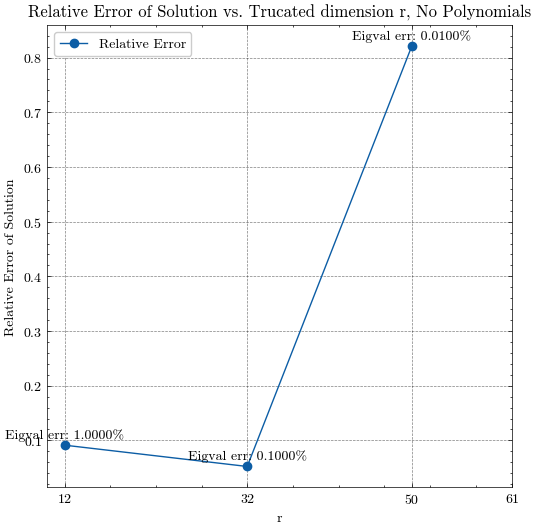

In [ ]:
plt.figure(figsize=(6, 6))
# plot the relative error as a function of r and label each with the corresponding error tolerance
plt.plot(max_idx_lst[:-1], relative_error_testing_window_lst, marker='o', label='Relative Error')

# mark the points with the corresponding snapshot energy
for i, txt in enumerate(err_tols[:-1]):
    plt.annotate(f"Eigval err: {txt:.4%}", (max_idx_lst[i], relative_error_testing_window_lst[i]), textcoords="offset points", xytext=(0,5), ha='center')

plt.xlabel("r")
plt.ylabel("Relative Error of Solution")
plt.title("Relative Error of Solution vs. Trucated dimension r, No Polynomials")
plt.xticks(max_idx_lst)
plt.legend()